In [136]:
from loader import get_nn_patients

In [156]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

### Preparing the data

In [138]:
radars, mats, patients, x, y = get_nn_patients()

In [139]:
radars.shape, mats.shape, patients.shape, x.shape, y.shape

((49, 857), (49, 857), (49, 857, 3), (49, 857, 2), (49, 857))

In [140]:
trainX, trainy = x[:34,:,:], y[:34,:]
testX, testy = x[34:,:,:], y[34:,:]
trainX.shape, trainy.shape, testX.shape, testy.shape

((34, 857, 2), (34, 857), (15, 857, 2), (15, 857))

In [132]:
trainX = trainX.reshape(29138,1,2)
trainy = trainy.reshape(29138)
testX = testX.reshape(12855,1,2)
testy = testy.reshape(12855)

In [117]:
trainy = to_categorical(trainy)
testy = to_categorical(testy)

In [125]:
trainX.shape, trainy.shape, testX.shape, testy.shape

((29138, 1, 2), (29138,), (12855, 1, 2), (12855,))

In [146]:
#my personal study, delete later
subject = 2
temptestX = temptrainX = trainX[subject,:,:].reshape(857,1,2)
temptesty = temptrainy = trainy[subject,:].reshape(857)
print(temptrainX.shape)
print(temptrainy.shape)

(857, 1, 2)
(857, 4)


In [160]:
verbose, epochs, batch_size = 0, 10, 32
n_timesteps, n_features, n_outputs = temptrainX.shape[1], temptrainX.shape[2], 4
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size = 1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(temptrainX, temptrainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
_, accuracy= model.evaluate(temptestX, temptesty, batch_size=batch_size, verbose=verbose)
pred = model.predict(temptestX, batch_size = batch_size, verbose=0)
pred_classes = pred.argmax(axis=-1)


2022-12-11 16:27:03.404226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 16:27:06.387151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 16:27:06.747100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [162]:
pred_classes.shape

(857,)

### Fitting the CNN model 
We will define the model as having two 1D CNN layers, followed by a dropout layer for regularization, then a pooling layer. It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1/4 their size, consolidating them to only the most essential elements.

After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction.

In [127]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

2022-12-11 00:31:27.442777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 00:32:47.196235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#1: 12.618


2022-12-11 00:32:50.419695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 00:34:09.646204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#2: 12.618


2022-12-11 00:34:12.627942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 00:35:32.618842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#3: 12.618


2022-12-11 00:35:35.320811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 00:36:54.520506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#4: 12.618


2022-12-11 00:36:56.997650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 00:38:19.143670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#5: 12.618


2022-12-11 00:38:22.511641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 00:39:49.150413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#6: 12.618


2022-12-11 00:39:52.630562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 00:41:20.767314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#7: 12.618


2022-12-11 00:41:23.720369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 00:42:52.784321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#8: 12.618


2022-12-11 00:42:55.878811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 00:44:19.399594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#9: 12.618


2022-12-11 00:44:22.460319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 00:45:46.497487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#10: 12.618
[12.617659568786621, 12.617659568786621, 12.617659568786621, 12.617659568786621, 12.617659568786621, 12.617659568786621, 12.617659568786621, 12.617659568786621, 12.617659568786621, 12.617659568786621]
Accuracy: 12.618% (+/-0.000)


### tuning the number of filters

2022-12-08 23:49:38.175177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:50:48.157379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #1: 56.702


2022-12-08 23:50:50.790723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:52:02.050191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #2: 42.979


2022-12-08 23:52:05.006622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:53:16.621154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #3: 56.702


2022-12-08 23:53:19.333078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:54:30.710041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #4: 64.629


2022-12-08 23:54:33.417849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:55:44.932609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #5: 65.531


2022-12-08 23:55:47.663085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:56:59.122523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #6: 62.380


2022-12-08 23:57:01.791895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:58:12.926926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #7: 59.852


2022-12-08 23:58:15.607044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:59:26.524587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #8: 64.574


2022-12-08 23:59:29.195091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:00:39.629585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #9: 65.531


2022-12-09 00:00:42.249964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:01:52.386281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #10: 65.531


2022-12-09 00:01:54.983659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:03:08.750729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #1: 64.629


2022-12-09 00:03:11.577024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:04:25.605273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #2: 65.585


2022-12-09 00:04:28.446969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:05:44.934588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #3: 65.585


2022-12-09 00:05:47.834151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:07:04.691681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #4: 65.531


2022-12-09 00:07:07.618747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:08:25.755764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #5: 57.767


2022-12-09 00:08:29.134140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:09:45.690533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #6: 65.531


2022-12-09 00:09:48.625057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:11:05.478552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #7: 65.585


2022-12-09 00:11:08.343717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:12:25.083387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #8: 64.574


2022-12-09 00:12:28.034524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:13:45.252719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #9: 59.907


2022-12-09 00:13:48.267186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:15:06.004722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #10: 65.585


2022-12-09 00:15:08.941120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:16:27.212837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #1: 64.629


2022-12-09 00:16:30.136596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:17:49.444189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #2: 65.585


2022-12-09 00:17:52.496644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:19:11.912544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #3: 66.169


2022-12-09 00:19:14.973719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:20:34.928461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #4: 64.629


2022-12-09 00:20:38.053609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:21:58.128008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #5: 65.585


2022-12-09 00:22:01.275005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:23:21.480123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #6: 65.212


2022-12-09 00:23:24.550435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:24:44.562306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #7: 59.907


2022-12-09 00:24:47.752228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:26:08.250688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #8: 64.629


2022-12-09 00:26:11.303619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:27:30.905840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #9: 66.169


2022-12-09 00:27:33.938428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:28:53.473987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #10: 67.546


2022-12-09 00:28:56.534334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:30:16.697638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #1: 68.611


2022-12-09 00:30:19.765174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:31:40.512668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #2: 68.611


2022-12-09 00:31:43.562187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:33:04.217047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #3: 67.655


2022-12-09 00:33:07.309059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:34:28.090324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #4: 68.611


2022-12-09 00:34:31.154915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:35:52.232005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #5: 68.129


2022-12-09 00:35:55.332358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:37:16.453558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #6: 68.611


2022-12-09 00:37:19.554683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:38:40.271134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #7: 67.172


2022-12-09 00:38:43.456704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:40:05.447205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #8: 67.172


2022-12-09 00:40:08.619006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:41:31.105167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #9: 61.626


2022-12-09 00:41:34.273581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:42:56.468133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #10: 68.129


2022-12-09 00:42:59.945195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:44:22.075728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #1: 67.655


2022-12-09 00:44:25.246100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:45:47.172844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #2: 67.826


2022-12-09 00:45:50.344761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:47:13.260146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #3: 68.611


2022-12-09 00:47:16.469341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:48:38.895435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #4: 66.519


2022-12-09 00:48:42.103648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:50:04.844786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #5: 68.611


2022-12-09 00:50:08.027282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:51:30.743442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #6: 67.826


2022-12-09 00:51:33.943158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:52:56.697635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #7: 67.826


2022-12-09 00:52:59.886473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:54:22.037143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #8: 67.826


2022-12-09 00:54:25.237645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:55:47.627679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #9: 67.826


2022-12-09 00:55:50.823939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:57:13.465067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #10: 65.562


2022-12-09 00:57:16.696179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 00:58:39.843653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #1: 66.869


2022-12-09 00:58:43.070929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:00:05.279737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #2: 66.869


2022-12-09 01:00:08.821806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:01:32.437385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #3: 65.562


2022-12-09 01:01:35.650154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:02:58.754013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #4: 67.655


2022-12-09 01:03:01.995738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:04:25.428735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #5: 66.869


2022-12-09 01:04:28.699963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:05:51.980593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #6: 66.869


2022-12-09 01:05:55.221365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:07:18.588004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #7: 67.305


2022-12-09 01:07:21.800238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:08:45.048754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #8: 66.869


2022-12-09 01:08:48.281617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:10:11.420828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #9: 68.611


2022-12-09 01:10:14.636966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:11:37.350867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #10: 68.611
[[56.70167803764343, 42.97938942909241, 56.70167803764343, 64.62855339050293, 65.530925989151, 62.38040328025818, 59.852200746536255, 64.57409858703613, 65.530925989151, 65.530925989151], [64.62855339050293, 65.5853807926178, 65.5853807926178, 65.530925989151, 57.76740908622742, 65.530925989151, 65.5853807926178, 64.57409858703613, 59.90665555000305, 65.5853807926178], [64.62855339050293, 65.5853807926178, 66.16880893707275, 64.62855339050293, 65.5853807926178, 65.21198153495789, 59.90665555000305, 64.62855339050293, 66.16880893707275, 67.54570603370667], [68.61143708229065, 68.61143708229065, 67.65461564064026, 68.61143708229065, 68.12913417816162, 68.61143708229065, 67.17231273651123, 67.17231273651123, 61.625832319259644, 68.12913417816162], [67.65461564064026, 67.82575249671936, 68.61143708229065, 66.51886701583862, 68.61143708229065, 67.82575249671936, 67.82575249671936, 67.82575249671936, 67.82575249671936, 65.56203961372375], [66.86892509460449, 66.86892509460

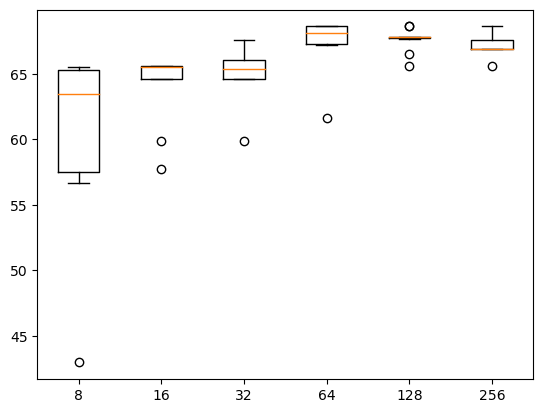

In [28]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_filters):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding = "same"))
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', padding = "same"))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_filters.png')

# run an experiment
def run_experiment(params, repeats=10):

    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)

# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)

### tuning size of kernel

2022-12-09 01:11:40.625763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:13:42.830584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #1: 68.611


2022-12-09 01:13:45.975408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:15:48.000320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #2: 66.348


2022-12-09 01:15:51.110035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:17:52.482647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #3: 67.172


2022-12-09 01:17:55.590817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:19:56.322615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #4: 66.285


2022-12-09 01:19:59.705256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:22:03.574966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #5: 68.028


2022-12-09 01:22:06.746397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:24:09.759562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #6: 65.212


2022-12-09 01:24:12.915093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:26:15.720524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #7: 68.129


2022-12-09 01:26:18.917009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:28:21.548241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #8: 67.655


2022-12-09 01:28:24.680082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:30:27.039662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #9: 68.028


2022-12-09 01:30:30.192521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:32:32.469785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #10: 67.655


2022-12-09 01:32:35.607305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:34:37.391847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #1: 67.546


2022-12-09 01:34:40.518863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:36:42.105988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #2: 67.242


2022-12-09 01:36:45.242998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:38:45.873755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #3: 68.611


2022-12-09 01:38:49.115710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:40:52.590756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #4: 67.655


2022-12-09 01:40:55.758727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:42:58.568157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #5: 67.305


2022-12-09 01:43:01.738403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:45:07.611151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #6: 68.028


2022-12-09 01:45:11.286740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:47:19.782772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #7: 67.655


2022-12-09 01:47:23.079046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:49:30.723364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #8: 67.172


2022-12-09 01:49:34.083837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:51:42.603888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #9: 67.655


2022-12-09 01:51:45.833042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:53:52.954885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #10: 68.611


2022-12-09 01:53:56.308087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:56:04.296897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #1: 68.611


2022-12-09 01:56:07.539004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 01:58:15.223764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #2: 66.869


2022-12-09 01:58:18.504239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:00:25.663098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #3: 67.655


2022-12-09 02:00:29.015960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:02:34.982682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #4: 67.655


2022-12-09 02:02:38.254960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:04:47.713104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #5: 68.611


2022-12-09 02:04:50.895099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:06:59.732899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #6: 68.611


2022-12-09 02:07:03.175357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:09:11.824984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #7: 62.933


2022-12-09 02:09:15.289674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:11:26.716771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #8: 67.655


2022-12-09 02:11:30.235125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:13:44.841156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #9: 67.655


2022-12-09 02:13:48.811577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:16:07.056165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #10: 67.655


2022-12-09 02:16:10.579631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:18:29.100189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #1: 66.869


2022-12-09 02:18:32.698267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:20:50.777708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #2: 68.611


2022-12-09 02:20:54.409788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:23:12.388510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #3: 67.655


2022-12-09 02:23:16.124601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:25:34.250840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #4: 66.348


2022-12-09 02:25:37.962578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:27:57.338600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #5: 62.147


2022-12-09 02:28:01.026614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:30:19.793560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #6: 68.611


2022-12-09 02:30:23.523543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:32:45.293333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #7: 68.611


2022-12-09 02:32:49.025140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:35:13.991748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #8: 66.348


2022-12-09 02:35:17.847048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:37:43.378349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #9: 67.172


2022-12-09 02:37:47.217798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:40:12.935168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #10: 67.655


2022-12-09 02:40:16.785864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:42:41.644394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #1: 68.611


2022-12-09 02:42:45.618973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:45:10.529766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #2: 66.869


2022-12-09 02:45:14.326375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:47:39.885531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #3: 68.611


2022-12-09 02:47:43.770446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:50:08.532477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #4: 67.655


2022-12-09 02:50:12.324636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:52:36.877381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #5: 67.655


2022-12-09 02:52:40.794999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:55:05.264159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #6: 68.028


2022-12-09 02:55:09.192435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 02:57:34.343321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #7: 67.826


2022-12-09 02:57:38.145089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:00:03.981328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #8: 67.172


2022-12-09 03:00:07.825784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:02:33.321825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #9: 68.611


2022-12-09 03:02:37.135442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:05:02.178732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #10: 67.655
[[68.61143708229065, 66.34773015975952, 67.17231273651123, 66.28549695014954, 68.0280089378357, 65.21198153495789, 68.12913417816162, 67.65461564064026, 68.0280089378357, 67.65461564064026], [67.54570603370667, 67.2423243522644, 68.61143708229065, 67.65461564064026, 67.30455756187439, 68.0280089378357, 67.65461564064026, 67.17231273651123, 67.65461564064026, 68.61143708229065], [68.61143708229065, 66.86892509460449, 67.65461564064026, 67.65461564064026, 68.61143708229065, 68.61143708229065, 62.93271780014038, 67.65461564064026, 67.65461564064026, 67.65461564064026], [66.86892509460449, 68.61143708229065, 67.65461564064026, 66.34773015975952, 62.147027254104614, 68.61143708229065, 68.61143708229065, 66.34773015975952, 67.17231273651123, 67.65461564064026], [68.61143708229065, 66.86892509460449, 68.61143708229065, 67.65461564064026, 67.65461564064026, 68.0280089378357, 67.82575249671936, 67.17231273651123, 68.61143708229065, 67.65461564064026]] [2, 3, 5, 7, 11]
Param=2:

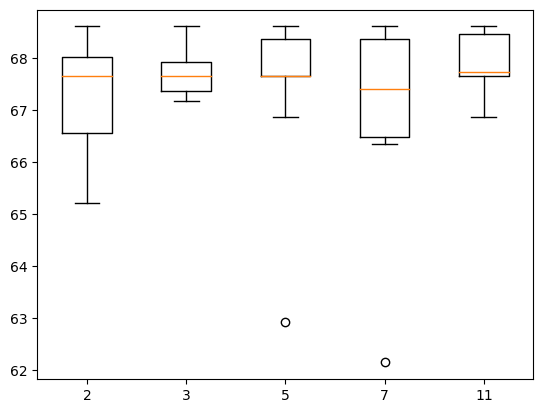

In [29]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_kernel):
    verbose, epochs, batch_size = 0, 15, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', input_shape=(n_timesteps,n_features), padding = "same"))
    model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', padding = "same"))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_kernel.png')

# run an experiment
def run_experiment(params, repeats=10):

    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)

# run the experiment
n_params = [2, 3, 5, 7, 11]
run_experiment(n_params)

In [30]:
# multi-channel cnn
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import concatenate

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=5, activation='relu', padding = "same")(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=1)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=128, kernel_size=7, activation='relu', padding = "same")(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=1)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=256, kernel_size=11, activation='relu', padding = "same")(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=1)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-09 03:05:06.127136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:06:52.736330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#1: 67.826
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-09 03:06:56.750022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:08:45.919928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#2: 68.611
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-09 03:08:50.183263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:10:39.692865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#3: 62.147
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-09 03:10:44.193551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:12:33.609467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#4: 68.611
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-09 03:12:37.740204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:14:26.462076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#5: 67.655
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-09 03:14:30.622112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:16:19.959288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#6: 68.611
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-09 03:16:24.116851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:18:15.925420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#7: 65.562
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-09 03:18:20.150250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:20:10.871255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#8: 67.305
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-09 03:20:15.204913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:22:06.604424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#9: 67.655
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-09 03:22:10.802153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 03:24:03.235396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#10: 65.562
[67.82575249671936, 68.61143708229065, 62.147027254104614, 68.61143708229065, 67.65461564064026, 68.61143708229065, 65.56203961372375, 67.30455756187439, 67.65461564064026, 65.56203961372375]
Accuracy: 66.954% (+/-1.926)
